# Librerías

In [2]:
# Utilidades generales
import os
import math
import random

import numpy as np

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Visualización
import matplotlib.pyplot as plt

In [3]:
# Semilla aleatoria
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

"""
"acelerar" la velocidad de entrenamiento de las redes neuronales al utilizar la GPU del computador (o cambiando el Runtime Type en Colab a uno con GPU)
Si presenta errores extraños ligados a "CUDA", settear esta variable como "cpu" (todo el notebook corre sin necesidad de usar GPU).
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


# Dataset 2D de Gaussianas

En lugar de trabajar con imágenes (como en los notebooks anteriores), en este experimento entrenamos un modelo de difusión sobre un dataset **bidimensional** generado artificialmente.  
Construimos dos distribuciones gaussianas en ℝ², cada una centrada en un punto distinto, y sampleamos puntos de ambas para formar un conjunto de entrenamiento simple pero no trivial.

Este tipo de dataset permite visualizar de manera directa el efecto del proceso de difusión y el reverse sampling, ya que cada muestra corresponde a un punto en el plano y no a una
imagen completa. Esto vuelve más interpretables las trayectorias y las formas de la
distribución aprendida.


In [4]:
DATASET = "gaussians"    # "gaussians" o "moons"
N_SAMPLES = 20000        # tamaño del dataset
BATCH_SIZE = 512

def sample_8gaussians(n):
    angles = np.linspace(0, 2*np.pi, 8, endpoint=False)
    centers = np.stack([np.cos(angles), np.sin(angles)], axis=1) * 2.5  # radio ~2.5
    idx = np.random.randint(0, 8, size=n)
    x = centers[idx] + 0.15*np.random.randn(n, 2)
    return x.astype(np.float32)

def sample_two_moons(n, noise=0.06):
    from sklearn.datasets import make_moons
    x, _ = make_moons(n_samples=n, noise=noise)
    x = x.astype(np.float32)
    # opcional: escalar un poco
    x *= 2.0
    return x

if DATASET == "gaussians":
    X = sample_8gaussians(N_SAMPLES)
elif DATASET == "moons":
    X = sample_two_moons(N_SAMPLES)
else:
    raise ValueError("DATASET debe ser 'gaussians' o 'moons'")

# TensorDataset y DataLoader (pasar a tensores para trabajar)
X_tensor = torch.from_numpy(X)  # (N, 2)
dataset = TensorDataset(X_tensor)  # solo X
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)


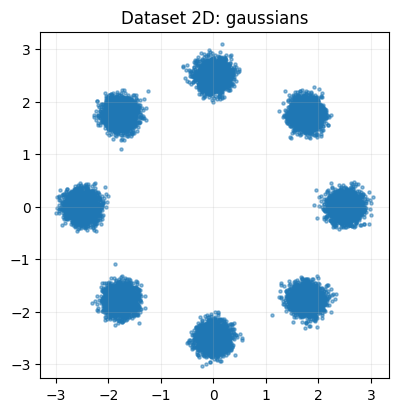

In [5]:
# Vista rápida del dataset
plt.figure(figsize=(4.5,4.5))
plt.scatter(X[:,0], X[:,1], s=5, alpha=0.5)
plt.title(f"Dataset 2D: {DATASET}")
plt.axis('equal'); plt.grid(alpha=0.2); plt.show()

# Formulas, parametros y herramientas para los tensores
parametros iguales, cambian $extract\_1d$ y $q\_sample\_2d$ solo para adaptarlas a la forma de los tensores

In [8]:
# Hiperparámetros de difusión (DDPM)
T = 1000                                                                        # pasos de difusión (subir a 1000 si hay paciencia)
beta_start, beta_end = 1e-4, 2e-2
betas = torch.linspace(beta_start, beta_end, T, dtype=torch.float32).to(device) # cuanto ruido nuevo se agrega en cada paso. crece linealmente

alphas = 1.0 - betas                                                 # cuanto se "conserva” de la señal previa en cada paso // fracción de señal que sobrevive
alphas_cumprod = torch.cumprod(alphas, dim=0)                        # pitatoria de los alphas hasta cad tiempo (tensor tambien) // cuánta señal original queda después de t pasos
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1,0), value=1.0)   # Ajuste para casos borde ¿? // agrega algunos 1.0 al tensor en no se cual posicion pa poder operar algunas cosas

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)                  # raiz del tensor alpha acumulado
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)  # raiz del tensor beta acumulado ¿?
sqrt_recip_alphas = torch.sqrt(1.0/alphas)                        # raiz del inverso de alpha acumulado

posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)   # \tilde{β}_t, varianza de 𝑞(𝑥_{𝑡−1}∣𝑥_𝑡,𝑥_0); para muestrear en el reverse (añadir el ruído correcto)

def extract_1d(a, t, B):
    """
    Extrae a[t] desde un tensor 1D de tamaño T y lo devuelve como (B,1),
    listo para hacer broadcast sobre un batch de puntos 2D.
    """
    out = a.gather(-1, t).float()
    return out.view(B, 1)

def q_sample_2d(x0, t, noise=None):
    """
    Fórmula cerrada de q(x_t | x_0) en el caso 2D:
        x_t = √\bar{α}_t * x_0 + √(1 - \bar{α}_t) * ε

    Permite obtener directamente el punto con ruido de nivel t sin simular paso a paso.
    """
    if noise is None:
        noise = torch.randn_like(x0)
    B = x0.size(0)
    return extract_1d(sqrt_alphas_cumprod, t, B) * x0 + \
           extract_1d(sqrt_one_minus_alphas_cumprod, t, B) * noise

# Red
Modelo: MLP 2D + embedding sinusoidal de t

La red utilizada acá es un perceptrón multicapa para trabajar con puntos 2D.  
Sus características principales:

- Entrada: un vector de dimensión 2 (la posición del punto).
- Embedding temporal sinusoidal + MLP, similar al usado en los modelos UNet, pero aplicado a vectores en vez de mapas espaciales.
- Salida: predicción del ruido ε que corresponde al paso de difusión t.

In [9]:
# Modelo: MLP

class SinusoidalPosEmb(nn.Module):
    """
    Embedding sinusoidal para el tiempo t, similar al positional encoding.
    Convierte t en un vector de dimensión 'dim'.
    """
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, t):
        # t: (B,) enteros -> embedding (B, dim)
        device = t.device
        half = self.dim // 2
        freqs = torch.exp(-math.log(10000) * torch.arange(0, half, dtype=torch.float32, device=device) / half)
        args = t.float().unsqueeze(1) * freqs.unsqueeze(0)
        return torch.cat([torch.sin(args), torch.cos(args)], dim=-1)

class MLP2D(nn.Module):
    """
    MLP simple para DDPM en dimensión 2.
    Recibe un punto x_t ∈ R² y el paso temporal t, y predice el ruido ε_t aplicado.
    """
    def __init__(self, time_dim=64, hidden=128):
        super().__init__()
        # Embedding sinusoidal del tiempo + MLP pequeño para refinarlo
        self.tok = SinusoidalPosEmb(time_dim)
        self.time_mlp = nn.Sequential(
            nn.Linear(time_dim, time_dim),
            nn.SiLU(),
            nn.Linear(time_dim, time_dim)
        )
        # Red totalmente conectada sobre [x_t, emb_t]
        self.net = nn.Sequential(
            nn.Linear(2 + time_dim, hidden), nn.SiLU(),
            nn.Linear(hidden, hidden), nn.SiLU(),
            nn.Linear(hidden, 2)   # salida en R²: ε_t
        )

    def forward(self, x, t):
        # Embedding temporal refinado
        te = self.time_mlp(self.tok(t))     # (B, time_dim)
        # Concatenar punto 2D con embedding de tiempo
        z  = torch.cat([x, te], dim=1)      # (B, 2+time_dim)
        # Predicción del ruido ε_t en R²
        return self.net(z)                  # (B, 2): prediccion de ε

# Entrenamiento

Entrenamiento: Minimizar $𝔼_{t,x_0,ε}$[ $||ε-ε_{θ}(x_{t}, t)||^2$ ]

$𝔼_{t,x_0,ε}$[ $||ε-ε_{θ}(\sqrt{\hat{α}}·x_0+\sqrt{1-\hat{α}}·ε, t)||^2$ ]



Intuitivamente: cada parámetro de la red (los pesos de sus neuronas) es una perilla que se puede girar.\
El objetivo es girarlas en la dirección que baja la pérdida $𝔼_{t,x_0,ε}$

#### cambia solo bajo la linea roja

- El modelo es **más pequeño**, ya que solo debe procesar vectores en ℝ² en lugar de imágenes.
- No usamos convoluciones ni UNet; en su lugar utilizamos una **MLP simple** (red totalmente conectada).
- La pérdida y el procedimiento de sampling son exactamente los mismos; lo que cambia es únicamente la arquitectura necesaria para datos de baja dimensión.

Esto permite ilustrar la idea central del DDPM sin la complejidad de una red grande.


In [10]:
# Entrenamiento
model = MLP2D(time_dim=64, hidden=256).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4) # optimizamos con descenso de gradiente ajustado para no sobre dimensionar errores y AdamW de algoritmo

loss_step_hist = []    # loss por iteración
loss_epoch_hist = []   # promedio por época

EPOCHS = 200      # "tandas" de entrenamiento // subir para mejor calidad // 100–300 típico en 2D; depende del dataset
LOG_EVERY = 100   # frecuencia de logging

model.train()    # inicia el entrenamiento

for epoch in range(1, EPOCHS+1):
    run, cnt = 0.0, 0
    for i, (x_batch,) in enumerate(loader):
        x = x_batch.to(device)              # (B,2)
        B = x.size(0)                       # tamaño del Batch
        t = torch.randint(0, T, (B,), device=device).long() # elige un t distinto unif para cada muestra, así el denoiser entrena parejo
        eps = torch.randn_like(x)           # ruido ε∼𝑁(0,𝐼) de igual dimension q x
        xt  = q_sample_2d(x, t, eps)        # genera x_t

        pred = model(xt, t)                 # prediccion del ruido ê
        loss = F.mse_loss(pred, eps)        # Pérdida MSE entre ruido predicho y real (ε-ê)

        optimizer.zero_grad()  # Pone los gradientes acumulados en cero antes del siguiente paso
        loss.backward()        # Calcula hacia atrás qué debe ajustar // calcula los gradientes de la pérdida con respecto a todos los parámetros del modelo
        optimizer.step()       # actualizar pesos (parámetros del modelo) // Usa los gradientes para actualizar los pesos (con AdamW)
        "--------------------------"
        lv = loss.item()
        loss_step_hist.append(lv)
        run += lv; cnt += 1

        if (i+1) % LOG_EVERY == 0:
            print(f"[Epoch {epoch:03d}] step {i+1}/{len(loader)} | loss {run/cnt:.4f}")
            run, cnt = 0.0, 0

    # promedio por época
    # (aprox: promedio de los últimos 'len(loader)' pasos)
    start = len(loss_step_hist) - len(loader)
    epoch_mean = float(np.mean(loss_step_hist[max(0,start):])) if len(loader)>0 else float(np.mean(loss_step_hist))
    loss_epoch_hist.append(epoch_mean)
    print(f"==> Epoch {epoch:03d} mean loss: {epoch_mean:.4f}")

==> Epoch 001 mean loss: 0.8586
==> Epoch 002 mean loss: 0.6175
==> Epoch 003 mean loss: 0.5094
==> Epoch 004 mean loss: 0.4102
==> Epoch 005 mean loss: 0.3800
==> Epoch 006 mean loss: 0.3726
==> Epoch 007 mean loss: 0.3734
==> Epoch 008 mean loss: 0.3770
==> Epoch 009 mean loss: 0.3851
==> Epoch 010 mean loss: 0.3784
==> Epoch 011 mean loss: 0.3825
==> Epoch 012 mean loss: 0.3806
==> Epoch 013 mean loss: 0.3712
==> Epoch 014 mean loss: 0.3786
==> Epoch 015 mean loss: 0.3729
==> Epoch 016 mean loss: 0.3780
==> Epoch 017 mean loss: 0.3766
==> Epoch 018 mean loss: 0.3746
==> Epoch 019 mean loss: 0.3793
==> Epoch 020 mean loss: 0.3798
==> Epoch 021 mean loss: 0.3741
==> Epoch 022 mean loss: 0.3822
==> Epoch 023 mean loss: 0.3772
==> Epoch 024 mean loss: 0.3738
==> Epoch 025 mean loss: 0.3733
==> Epoch 026 mean loss: 0.3744
==> Epoch 027 mean loss: 0.3670
==> Epoch 028 mean loss: 0.3712
==> Epoch 029 mean loss: 0.3793
==> Epoch 030 mean loss: 0.3758
==> Epoch 031 mean loss: 0.3794
==> Epoc

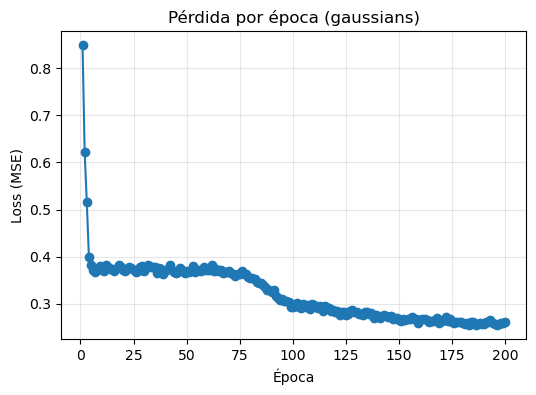

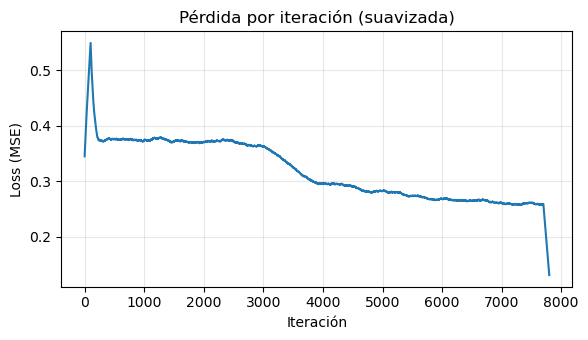

In [ ]:
# Visualizar funcion de perdida por epoch
plt.figure(figsize=(6,4))
plt.plot(range(1, len(loss_epoch_hist)+1), loss_epoch_hist, marker='o')
plt.xlabel("Época"); plt.ylabel("Loss (MSE)"); plt.title(f"Pérdida por época ({DATASET})")
plt.grid(alpha=0.3); plt.show()

def smooth(y, k=100):
    k = max(1,int(k))
    f = np.ones(k)/k
    return np.convolve(np.array(y, dtype=float), f, mode='same')
plt.figure(figsize=(6,3.5))
plt.plot(smooth(loss_step_hist, k=200))
plt.xlabel("Iteración"); plt.ylabel("Loss (MSE)"); plt.title("Pérdida por iteración (suavizada)")
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# Denosising

El sampling sigue exactamente la misma teoría que en los modelos de imágenes:
$
x_{t-1} = \mu_\theta(x_t, t) + \sigma_t z
$

La diferencia es que aquí el muestreo produce puntos en el plano ℝ², por lo que podemos:
- visualizar cada paso sin necesidad de mostrar imágenes
- graficar la evolución completa de la nube
- ver el transporte de masa entre distribuciones de forma muy intuitiva.


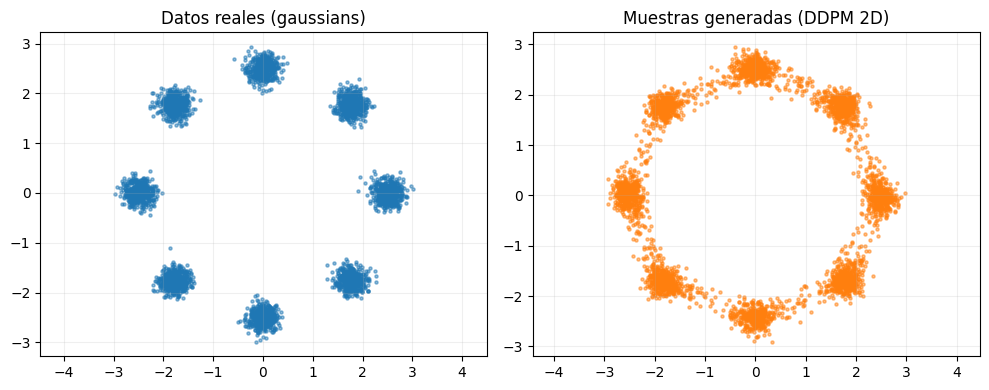

In [11]:
# Sampling: generar imágenes desde ruido

@torch.no_grad()
def p_step(model, x, t):
    """
    Un paso del proceso inverso p(x_{t-1} | x_t) en R².
    Utiliza la fórmula cerrada del posterior y el ruido ε̂ predicho por el modelo.
    """
    B = x.size(0)
    # Coeficientes para este t (dimensión (B,1) para broadcast en R²)
    betas_t = extract_1d(betas, t, B)                        # (B,1)
    sqrt_one_minus_ab_t = extract_1d(sqrt_one_minus_alphas_cumprod, t, B)
    sqrt_recip_alphas_t = extract_1d(sqrt_recip_alphas, t, B)

    # Media del posterior usando la estimación del ruido ε̂(x_t, t)
    model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t) / sqrt_one_minus_ab_t)  # (B,2)

    # En t = 0 no se agrega ruido; la muestra final debe ser determinista
    if (t == 0).all():
        return model_mean
    else:
        post_var_t = extract_1d(posterior_variance, t, B)    # (B,1)
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(post_var_t) * noise

@torch.no_grad()
def sample_2d(model, n=2000, n_steps=T):
    """
    Muestreo completo: comienza desde ruido N(0, I) en R²
    y aplica p_step desde t = T-1 hasta t = 0.
    """
    x = torch.randn((n,2), device=device)  # x_T ~ N(0,I)
    model.eval()
    for i in reversed(range(0, n_steps)):
        t = torch.full((n,), i, device=device, dtype=torch.long)
        x = p_step(model, x, t)
    return x


# -------- Visualización: real vs generado --------
gen = sample_2d(model, n=4000)
gen_np = gen.detach().cpu().numpy()

plt.figure(figsize=(10,4))
# Datos reales
plt.subplot(1,2,1)
plt.scatter(X[:4000,0], X[:4000,1], s=5, alpha=0.5)
plt.title(f"Datos reales ({DATASET})")
plt.axis('equal'); plt.grid(alpha=0.2)

# Datos generados por el DDPM
plt.subplot(1,2,2)
plt.scatter(gen_np[:,0], gen_np[:,1], s=5, alpha=0.5, c='tab:orange')
plt.title("Muestras generadas (DDPM 2D)")

plt.axis('equal'); plt.grid(alpha=0.2)
plt.tight_layout(); plt.show()

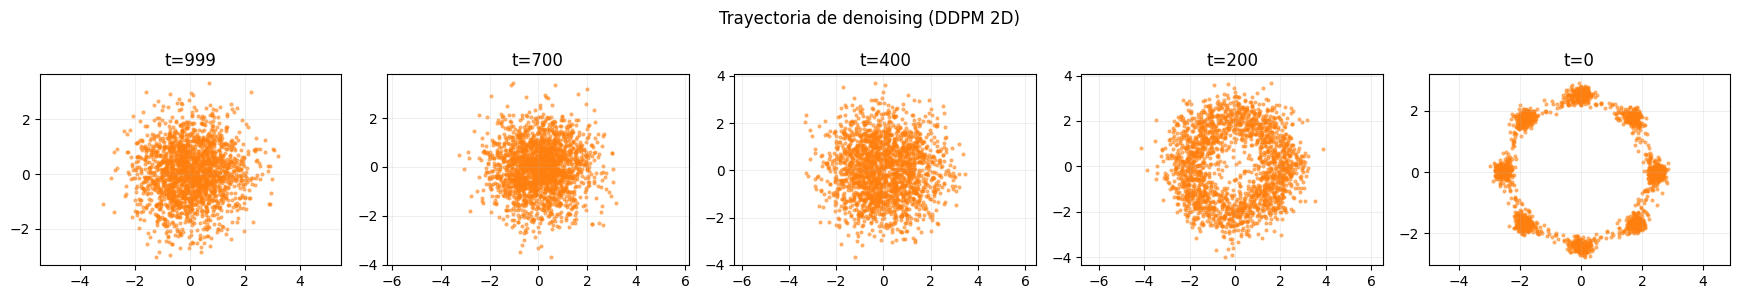

In [12]:
# Visualizar trayectoria de denoising (varios tiempos)
@torch.no_grad()
def denoise_trajectory_2d(model, n=1000, steps_to_show=(T-1, int(T*0.7), int(T*0.4), int(T*0.2), 0)):
    """
    Muestra cómo evoluciona un conjunto de puntos x_t en R²
    a medida que aplicamos el proceso inverso desde t = T-1 hasta t = 0.
    Guarda "fotografías" en los tiempos indicados en steps_to_show.
    """
    pts = torch.randn((n,2), device=device)  # x_T
    snaps = {}
    model.eval()
    for i in reversed(range(0, T)):
        t = torch.full((n,), i, device=device, dtype=torch.long)
        pts = p_step(model, pts, t)
        # Guardar en los tiempos seleccionados
        if i in steps_to_show:
            snaps[i] = pts.detach().cpu().numpy()
    return snaps

steps = (T-1, int(T*0.7), int(T*0.4), int(T*0.2), 0)
snapshots = denoise_trajectory_2d(model, n=2000, steps_to_show=steps)

# Plotear la evolución de la nube de puntos en distintos tiempos t
cols = len(steps)
plt.figure(figsize=(3.5*cols, 3))
for j, s in enumerate(steps):
    plt.subplot(1, cols, j+1)
    S = snapshots[s]
    plt.scatter(S[:,0], S[:,1], s=4, alpha=0.5, c='tab:orange')
    plt.title(f"t={s}")
    plt.axis('equal'); plt.grid(alpha=0.2)


plt.suptitle("Trayectoria de denoising (DDPM 2D)")
plt.tight_layout(); plt.show()